In [4]:
pip install catboost

     |████████████████████████████████| 67.4 MB 36 kB/s 


In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import missingno as msno
import itertools
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [8]:
rc('font', family='NanumGothic')
rc('axes', unicode_minus=False)
sns.set_style("darkgrid")
sns.set_palette("muted")

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
file_root_path = '/content/drive/MyDrive/AIffel2021/PayMeBack/data'
os.listdir(file_root_path)

['train.csv', 'test.csv', 'sample_submission.csv']

In [110]:
train_df = pd.read_csv(file_root_path+'/train.csv')
test_df = pd.read_csv(file_root_path+'/test.csv')
sample_submission_df = pd.read_csv(file_root_path+'/sample_submission.csv')

#**혜림님의 노트북을 기반으로 작성하였습니다**

## 데이터 변수 설명
https://www.dacon.io/competitions/official/235713/talkboard/402821/    
* index
* gender: 성별
    ['M', 'F']
* car: 차량 소유 여부
    ['Y','N']  -> 소유 여부를 0, 1로 바꿔줘야 한다.
* reality: 부동산 소유 여부
    ['Y','N']  -> 소유 여부를 0, 1로 바꿔줘야 한다.
* child_num: 자녀 수
* income_total: 연간 소득 -> 연속형 데이터로 범주화가 필요하다.
* income_type: 소득 분류 -> 연간 소득과 소득 분류가 관계가 있는지 확인해봐야겠다.
    ['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
* edu_type: 교육 수준 -> 연간 소득과 교육 수준의 관계를 확인해야 겠다.
    ['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
    고등교육, 중등교육, 고등교육 자퇴, 중등교육보다 낮음, 학사학위 -> 교육수준에 따른 서열이 존재할 것이라 예상
    
* family_type: 결혼 여부
    ['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']

* house_type: 생활 방식
    ['Municipal apartment', 'House / apartment', 'With parents', 'Co-op apartment', 'Rented apartment', 'Office apartment']

* DAYS_BIRTH: 출생일
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미    
    나이로 변환해서 사용가능

* DAYS_EMPLOYED: 업무 시작일
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미    
    양수 값은 고용되지 않은 상태를 의미함

* FLAG_MOBIL: 핸드폰 소유 여부
    [0,1]

* work_phone: 업무용 전화 소유 여부
    [0,1]

* phone: 전화 소유 여부
    [0,1]

* email: 이메일 소유 여부

* occyp_type: 직업 유형													
    연간 소득과 교육수준과 비교할 수 있을 것 같다.

* family_size: 가족 규모
* begin_month: 신용카드 발급 월
    데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
* credit: 사용자의 신용카드 대금 연체를 기준으로 한 신용도
    => 낮을 수록 높은 신용의 신용카드 사용자를 의미함

# 1. 데이터 살펴보기

In [12]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [13]:
test_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [14]:
sample_submission_df.head()

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0


In [15]:
print(f'train shape: {train_df.shape}')
print(f'test shape: {test_df.shape}')
print(f'submission shaep: {sample_submission_df.shape}')

train shape: (26457, 20)
test shape: (10000, 19)
submission shaep: (10000, 4)


# EDA

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

occyp_type에 결측치가 존재한다.

In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          10000 non-null  int64  
 1   gender         10000 non-null  object 
 2   car            10000 non-null  object 
 3   reality        10000 non-null  object 
 4   child_num      10000 non-null  int64  
 5   income_total   10000 non-null  float64
 6   income_type    10000 non-null  object 
 7   edu_type       10000 non-null  object 
 8   family_type    10000 non-null  object 
 9   house_type     10000 non-null  object 
 10  DAYS_BIRTH     10000 non-null  int64  
 11  DAYS_EMPLOYED  10000 non-null  int64  
 12  FLAG_MOBIL     10000 non-null  int64  
 13  work_phone     10000 non-null  int64  
 14  phone          10000 non-null  int64  
 15  email          10000 non-null  int64  
 16  occyp_type     6848 non-null   object 
 17  family_size    10000 non-null  float64
 18  begin_m

test에서도 동일하게 occyp_type에 결측치가 존재한다.

## 신용 등급 비율

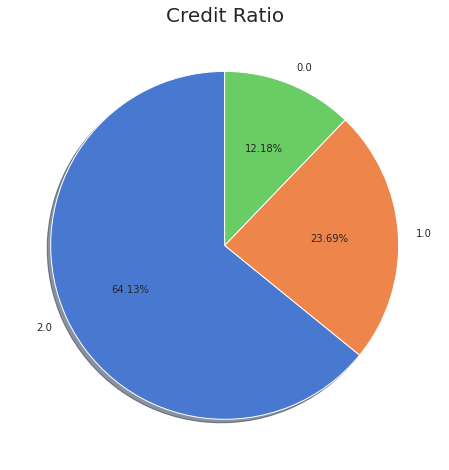

In [18]:
plt.subplots(figsize = (8,8))
plt.pie(train_df['credit'].value_counts(), labels = train_df['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit Ratio', size=20)
plt.show()

값이 낮을 수록 높은 신용등급을 가진 사용자를 의미한다. 따라서 낮은 신용등급을 가진 사용자가 많다는 것을 알 수 있다.

## 신용 등급에 따른 성비

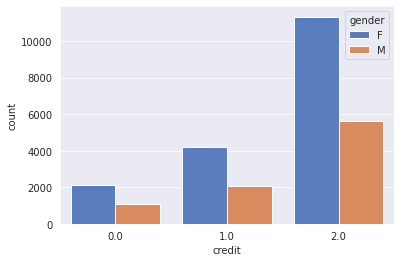

In [19]:
sns.countplot(data=train_df, x='credit', hue='gender')

모든 등급에서 남성보다 여성이 많았고,     
위의 pie chart에서 본 것 과 같이 사용자 중 신용 등급이 높은 사람보다 낮은 사람이 많다는 것을 알 수 있다.

## 신용 등급에 따른 차량 소유 여부

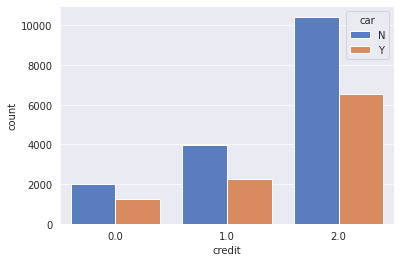

In [20]:
sns.countplot(data=train_df, x='credit', hue='car')

모든 등급에서 차를 소유하지 않은 사람이 더 많았다.

## 신용 등급에 따른 부동산 소유 여부

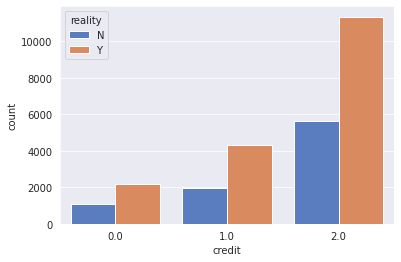

In [21]:
sns.countplot(data=train_df, x='credit', hue='reality')

모든 등급에서 부동산을 소유한 사람이 더 많았다.

## 신용 등급에 따른 소득 분류의 차이

In [22]:
income_type_ratio_by_credit = train_df.groupby(['credit', 'income_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','income_type' : 'income_type', 'index':'count'})
income_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
income_type_ratio_by_credit

,credit,income_type,count
2,0.0,State servant,265
1,0.0,Pensioner,536
0,0.0,Commercial associate,782
3,0.0,Working,1639
7,1.0,Student,3
6,1.0,State servant,489
5,1.0,Pensioner,1084
4,1.0,Commercial associate,1344
8,1.0,Working,3347
12,2.0,Student,4


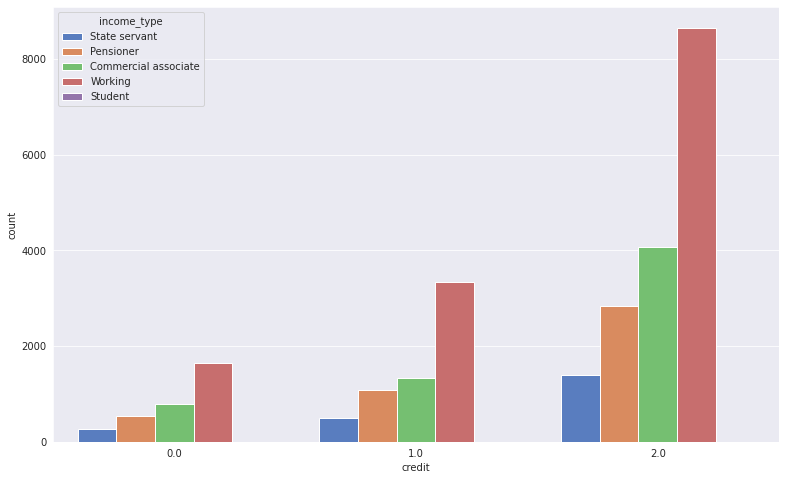

In [23]:
plt.figure(figsize = (13,8))
sns.barplot(data=income_type_ratio_by_credit, x='credit', y='count', hue='income_type')

student부분이 잘 안보여서 student만 따로 시각화하였다.

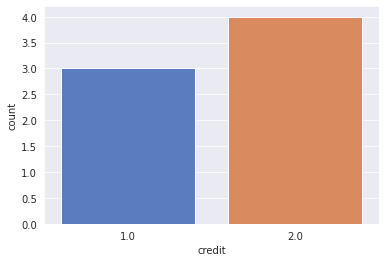

In [24]:
temp = income_type_ratio_by_credit.loc[income_type_ratio_by_credit['income_type'] == 'Student']
sns.barplot(data=temp, x='credit', y='count')

학생은 0 신용등급을 가진 사람이 없고, 낮은 등급에도 1에는 3명, 2에는 4명 정도로 적게 있는 것을 알 수 있다.    
등급에 상관없이 사용자가 많은 직업군은    
State servant < Pensioner < Commercial associate < Working 이다.

## 신용 등급에 따른 교육 수준

In [25]:
edu_type_ratio_by_credit = train_df.groupby(['credit', 'edu_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','edu_type' : 'edu_type', 'index':'count'})
edu_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
edu_type_ratio_by_credit

,credit,edu_type,count
0,0.0,Academic degree,2
3,0.0,Lower secondary,28
2,0.0,Incomplete higher,114
1,0.0,Higher education,909
4,0.0,Secondary / secondary special,2169
5,1.0,Academic degree,7
8,1.0,Lower secondary,59
7,1.0,Incomplete higher,246
6,1.0,Higher education,1751
9,1.0,Secondary / secondary special,4204


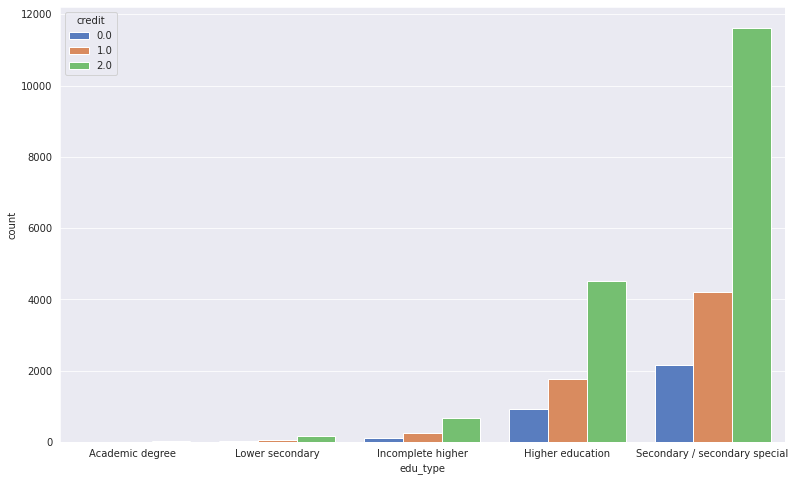

In [26]:
plt.figure(figsize = (13,8))
sns.barplot(data=edu_type_ratio_by_credit, x='edu_type', y='count', hue='credit')

모든 등급에 상관 없이 교육 수준의 순위가 같았다.    
Academic degree < Lower secondary < Incomplete higher < Higher education < Secondary

## 신용 등급에 따른 결혼 여부

In [27]:
family_type_ratio_by_credit = train_df.groupby(['credit', 'family_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','family_type' : 'family_type', 'index':'count'})
family_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
family_type_ratio_by_credit

,credit,family_type,count
4,0.0,Widow,126
2,0.0,Separated,193
0,0.0,Civil marriage,288
3,0.0,Single / not married,402
1,0.0,Married,2213
9,1.0,Widow,299
7,1.0,Separated,349
5,1.0,Civil marriage,539
8,1.0,Single / not married,940
6,1.0,Married,4140


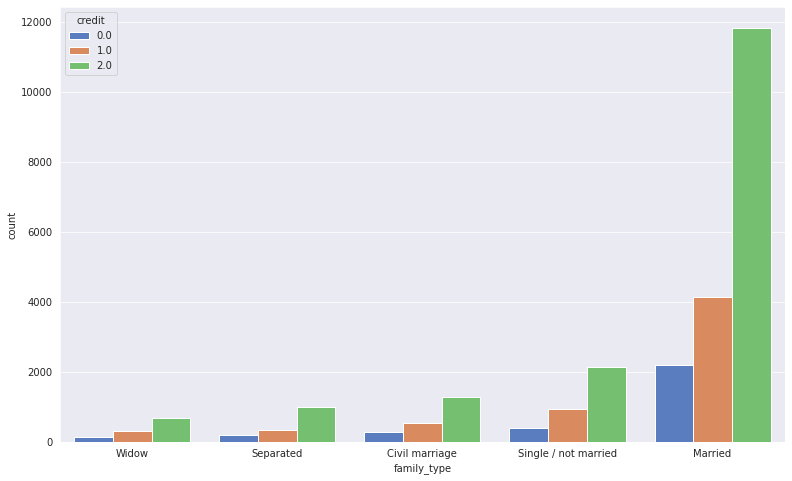

In [28]:
plt.figure(figsize = (13,8))
sns.barplot(data=family_type_ratio_by_credit, x='family_type', y='count', hue='credit')

신용 등급에 상관 없이 가족 형태에 따른 순위는 동일했다.    
또, 모든 등급과 상관없이 결혼한 사람들이 상대적으로 많이 존재한다.

## 신용 등급에 따른 가족 수 차이

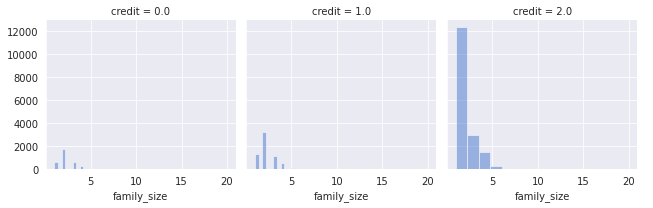

In [112]:
grid = sns.FacetGrid(data=train_df, col='credit')
grid.map(plt.hist, 'family_size', alpha=.5, bins=15)
grid.add_legend()

가족수가 두명인 사람들이 많았다. 위 그래프에서 결혼한 사람이 많은 것에 영향을 받았을 거라 추측한다.

## 신용 등급에 따른 자녀 수의 차이

In [31]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


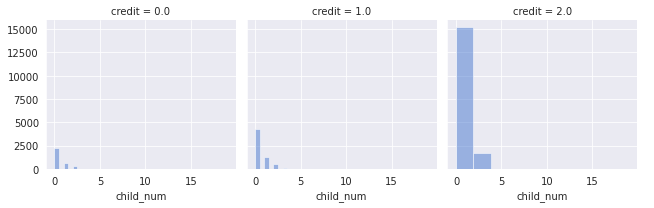

In [114]:
grid = sns.FacetGrid(data=train_df, col='credit')
grid.map(plt.hist, 'child_num', alpha=.5)
grid.add_legend()

자녀 수도 신용 등급에 따라 차이가 있어보이진 않는다.    
그래프 형태로 보아 범주형 데이터로 바꿔야 할 것 같다.    

위의 가족수와 결혼 여부 시각화 결과를 보고 추측하는 바로는 결혼은 했지만 아이를 낳지 않은 가족이 많다는 것을 알 수 있다.

## 신용 등급에 따른 생활 방식 차이

In [33]:
house_type_ratio_by_credit = train_df.groupby(['credit', 'house_type'])['index'].count()\
                        .reset_index()\
                        .rename(columns={'credit':'credit','house_type' : 'house_type', 'index':'count'})
house_type_ratio_by_credit.sort_values(by=['credit', 'count'], inplace=True)
house_type_ratio_by_credit

,credit,house_type,count
0,0.0,Co-op apartment,14
3,0.0,Office apartment,24
4,0.0,Rented apartment,50
2,0.0,Municipal apartment,110
5,0.0,With parents,151
1,0.0,House / apartment,2873
6,1.0,Co-op apartment,30
9,1.0,Office apartment,48
10,1.0,Rented apartment,147
8,1.0,Municipal apartment,160


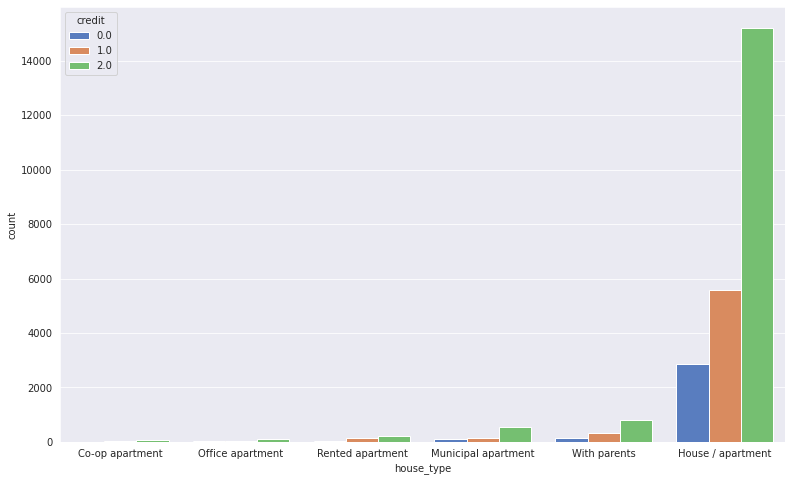

In [34]:
plt.figure(figsize = (13,8))
sns.barplot(data=house_type_ratio_by_credit, x='house_type', y='count', hue='credit')

신용 등급에 상관없이 생활 방식은 순위가 동일했다.    
상대적으로 많이 존재하는 생활 방식은 House/apartment이다.

## 신용등급에 따른 휴대폰 소지여부

Text(0.5, 1.0, 'credit=2')

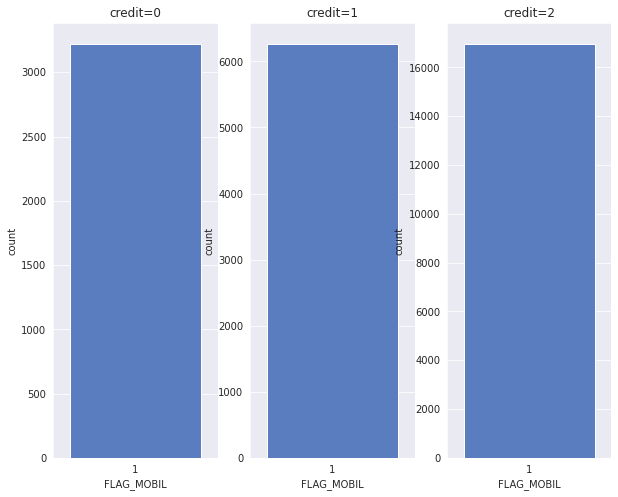

In [35]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='FLAG_MOBIL', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='FLAG_MOBIL', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='FLAG_MOBIL', ax=axes[2])
axes[2].set_title('credit=2')

In [36]:
print('휴대전화를 가지고 있는 비율:', (train_df.FLAG_MOBIL.sum()/len(train_df))*100)

휴대전화를 가지고 있는 비율: 100.0


모든 사람이 휴대전화를 가지고 있다는 것을 알 수 있다.    
추후 이부분은 삭제해도 무방할 데이터라고 생각한다.

##  신용 등급에 따른 업무용 전화 소지여부

Text(0.5, 1.0, 'credit=2')

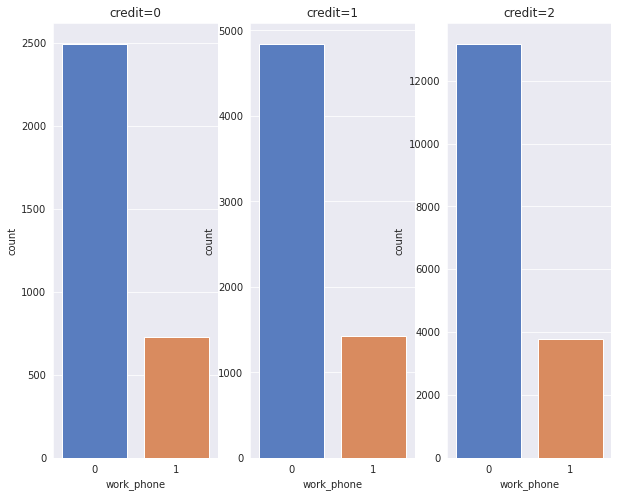

In [37]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='work_phone', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='work_phone', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='work_phone', ax=axes[2])
axes[2].set_title('credit=2')

## 신용 등급에 따른 전화 소지여부

Text(0.5, 1.0, 'credit=2')

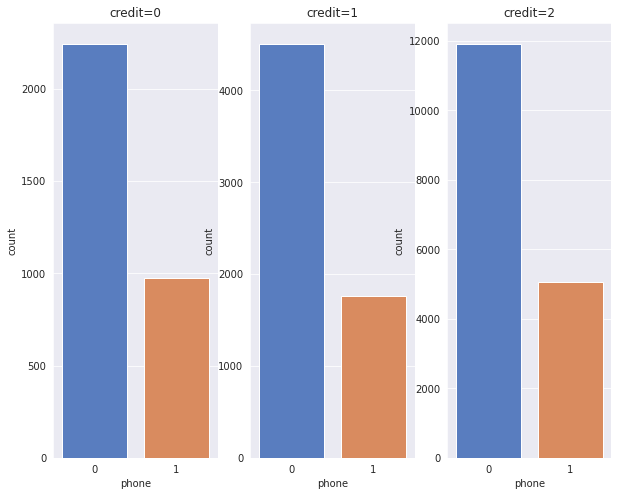

In [38]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='phone', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='phone', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='phone', ax=axes[2])
axes[2].set_title('credit=2')

## 신용 등급에 따른 이메일 소지여부

Text(0.5, 1.0, 'credit=2')

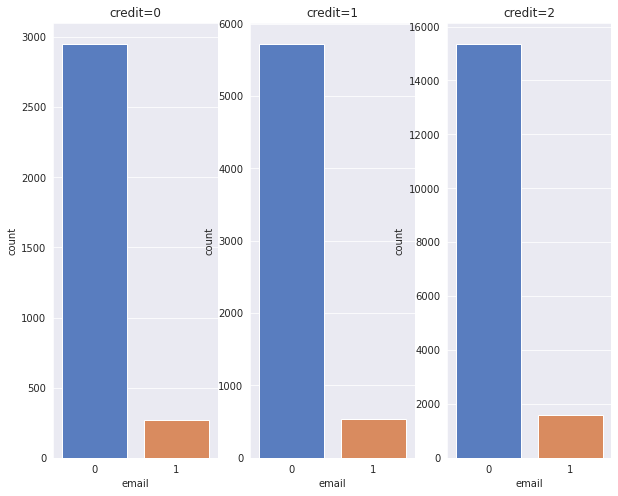

In [39]:
flg, axes = plt.subplots(1,3,figsize=(10,8))

sns.countplot(data=train_df.loc[train_df.credit==0], x='email', ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=train_df.loc[train_df.credit==1], x='email', ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=train_df.loc[train_df.credit==2], x='email', ax=axes[2])
axes[2].set_title('credit=2')

소지여부 시각화를 종합해서 분석해보면 등급에 상관없이 업무용 전화, 전화, 이메일을 소지하지 않은 사람이 많았다.

## 신용 등급에 따른 직업 유형

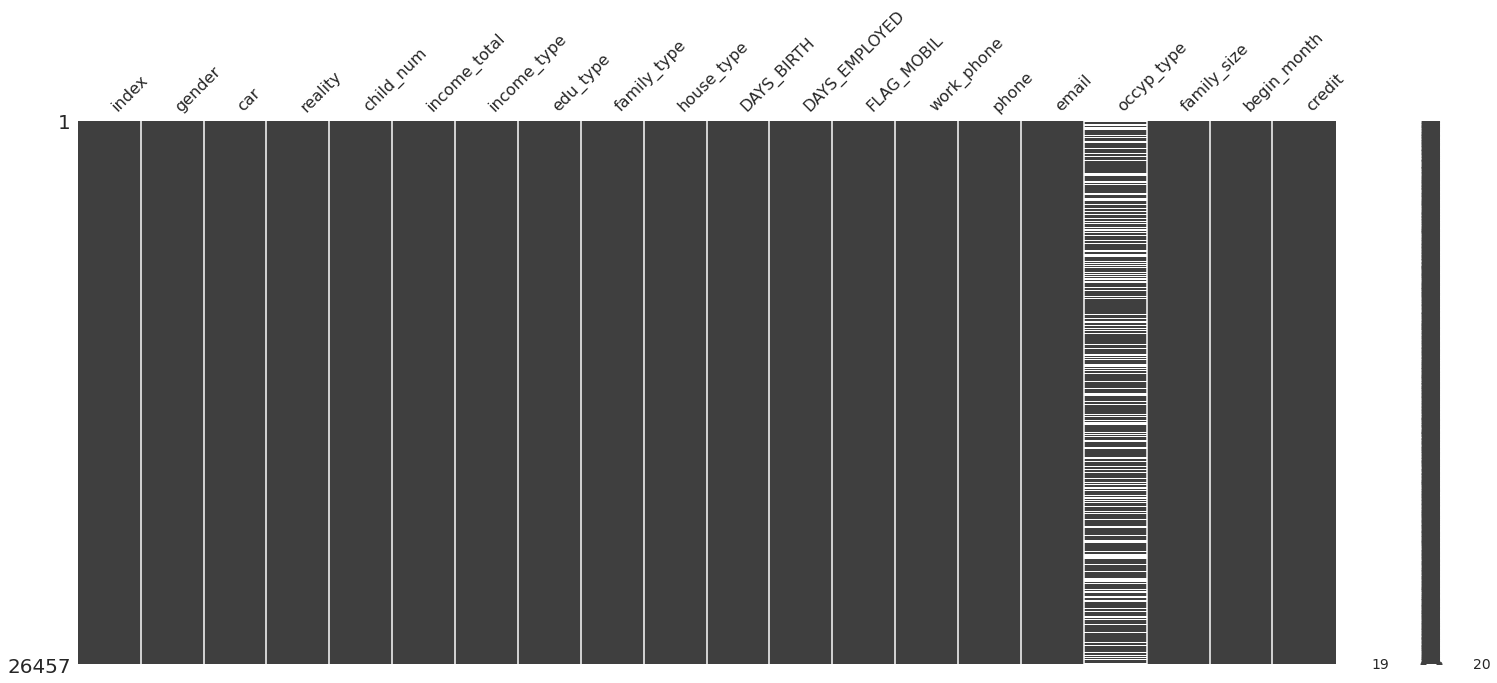

In [40]:
msno.matrix(train_df)

occyp_type가 결측치가 존재하므로 빈 값을 no job으로 채워서 시각화한다.

In [41]:
temp= train_df.copy()
temp.occyp_type.fillna('no_job', inplace=True)

Text(0.5, 1.0, 'credit=2')

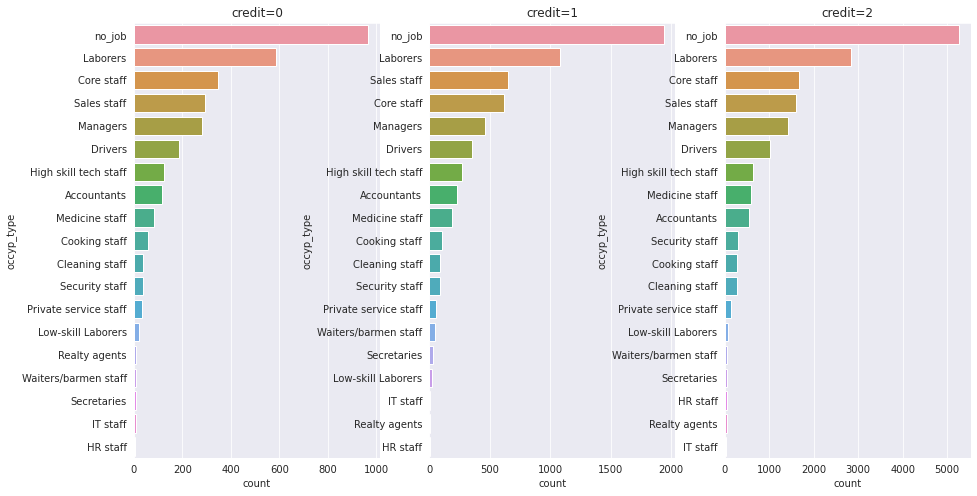

In [42]:
flg, axes = plt.subplots(1,3,figsize=(15,8))

sns.countplot(data=temp.loc[temp.credit==0], y='occyp_type', order=temp.loc[temp.credit==0,'occyp_type'].value_counts().index, ax=axes[0])
axes[0].set_title('credit=0')
sns.countplot(data=temp.loc[temp.credit==1], y='occyp_type', order=temp.loc[temp.credit==1,'occyp_type'].value_counts().index, ax=axes[1])
axes[1].set_title('credit=1')
sns.countplot(data=temp.loc[temp.credit==2], y='occyp_type', order=temp.loc[temp.credit==2,'occyp_type'].value_counts().index, ax=axes[2])
axes[2].set_title('credit=2')

직업 유형은 신용등급에 따라 미세하게 차이가 난다.

## 신용 등급에 따른 연간 소득 차이

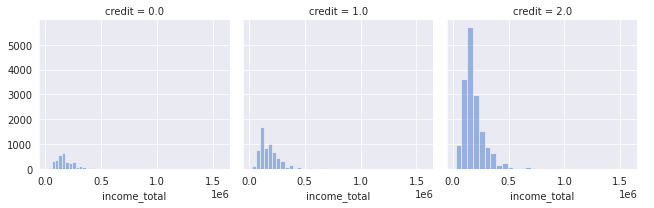

In [50]:
grid = sns.FacetGrid(data=train_df, col='credit')
grid.map(plt.hist, 'income_total', alpha=.5, bins=30)
grid.add_legend()

신용 등급에 따라 연간 소득의 차이는 없어보인다.

## 신용 등급에 따른 연령대 차이

In [53]:
temp=train_df.copy()
temp['age'] = -temp['DAYS_BIRTH']//365

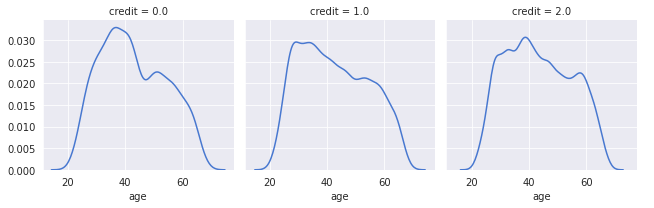

In [58]:
grid = sns.FacetGrid(data=temp, col='credit')
grid.map(sns.kdeplot, 'age')
grid.add_legend()

등급별로 차이는 없지만 20\~30대와 60대의 비율이 낮다.    
아무래도 20\~30대는 학생과 사회 초년생이 많고, 60대 이상은 경제활동이 적어진다고 예측할 수 있다.

## 신용 등급에 따른 업무 기간의 차이
DAYS_EMPLOYED는 무직인 경우이므로 0으로 값을 대체한다.

In [60]:
temp=train_df.copy()
temp.loc[temp['DAYS_EMPLOYED'] >= 0, 'DAYS_EMPLOYED'] = 0
temp['career_year'] = round(-temp['DAYS_EMPLOYED']/365,2)

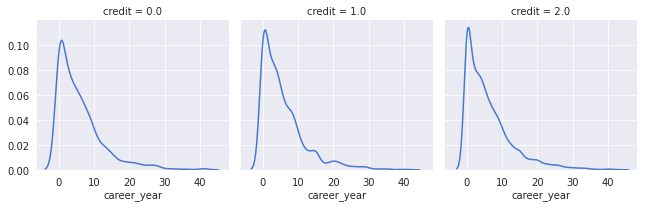

In [62]:
grid = sns.FacetGrid(data=temp, col='credit')
grid.map(sns.kdeplot, 'career_year')
grid.add_legend()

 신용 등급별로 차이는 없으나 무직인 사람이 비율이 가장 많고, 경력이 많아질수록 비율은 떨어진다.

## 신용 등급에 따른 카드 발급 기간의 차이
Month를 Year로 바꿔서 시각화하였다.

In [64]:
temp=train_df.copy()
temp['begin_year'] = round(-temp['begin_month']/12, 2)

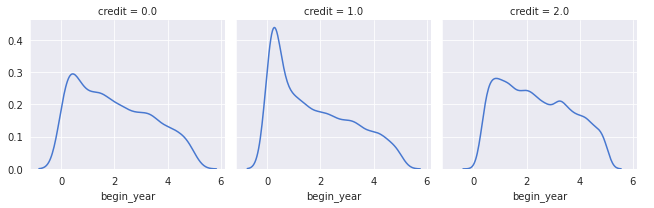

In [65]:
grid = sns.FacetGrid(data=temp, col='credit')
grid.map(sns.kdeplot, 'begin_year')
grid.add_legend()

만든지 1년 이하의 사용자들이 많은 것을 볼 수 있다.

# 데이터 전처리

## 1. 결측치 처리

In [115]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

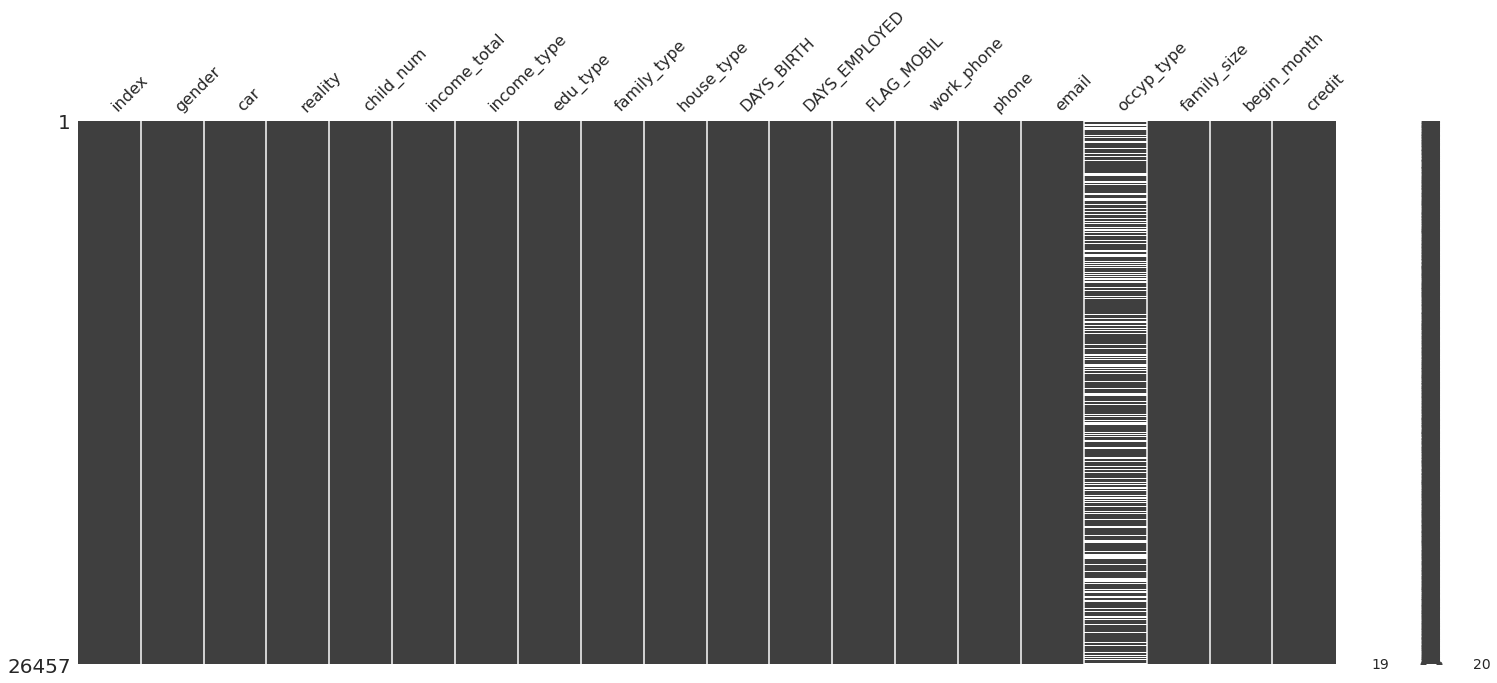

In [116]:
msno.matrix(train_df)

In [117]:
# occyp_type이 null인 비율
print(round(train_df.occyp_type.isnull().sum()/len(train_df), 2)*100,'%')

31.0 %


null 값을 백수라고 가정하고 no_job으로 채운다.

In [118]:
train_df.occyp_type.fillna('no jobs', inplace=True)
test_df.occyp_type.fillna('no jobs', inplace=True)

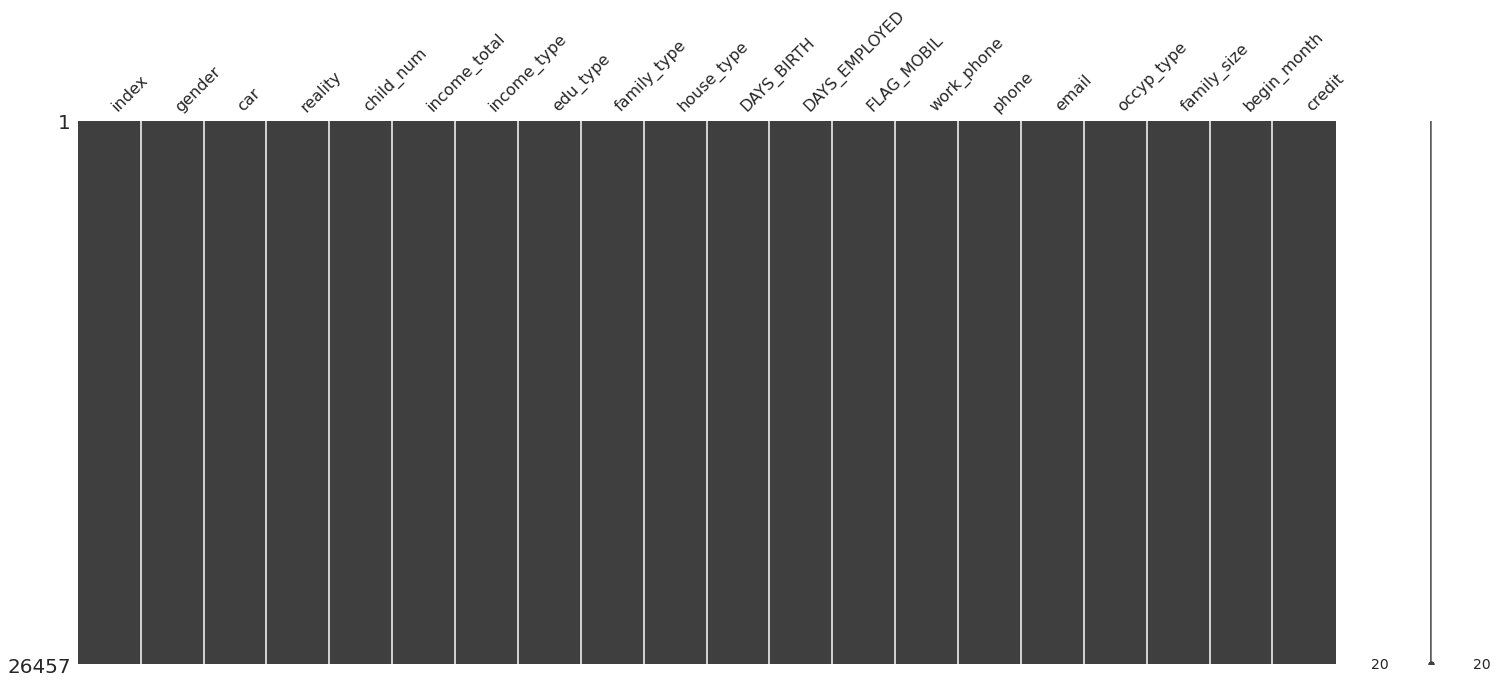

In [119]:
# 확인
msno.matrix(train_df)

## 2. 이진 카테고리 데이터를 숫자형으로 변환
gender, car, reality는 이진 카테고리이므로 숫자형으로 변환한다.
(이진 카테고리: 카테고리 값이 두개밖에 없다.)

In [120]:
# 정말 이진 카테고리값인지 확인한다.
print('gender: ', train_df['gender'].unique())
print('car: ', train_df['car'].unique())
print('reality: ', train_df['reality'].unique())

gender:  ['F' 'M']
car:  ['N' 'Y']
reality:  ['N' 'Y']


In [121]:
# gender
train_df['gender'] = train_df['gender'].replace(['F', 'M'], [0,1])
test_df['gender'] = test_df['gender'].replace(['F', 'M'], [0,1])

# car
train_df['car'] = train_df['car'].replace(['N', 'Y'], [0,1])
test_df['car'] = test_df['car'].replace(['N', 'Y'], [0,1])

# reality
train_df['reality'] = train_df['reality'].replace(['N', 'Y'], [0,1])
test_df['reality'] = test_df['reality'].replace(['N', 'Y'], [0,1])

## 3. 연속형 변수를 순서형 변수로 변환

### 1) child_num
자녀 수는 범주형 변수로 봐도 되지만 시각화해본 결과 범위가 커서 순서형으로 나누려고 한다.    

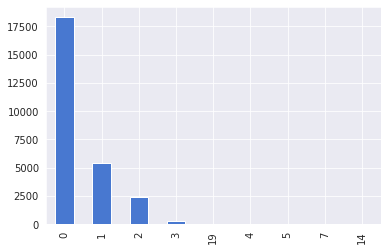

In [122]:
train_df['child_num'].value_counts(sort=False).plot.bar()

In [123]:
round(train_df.loc[train_df['child_num']>=3, 'index'].count()/len(train_df),2)*100

1.0

자녀수가 3명 이상인 경우가 1%밖에 안되므로 3명 이상을 하나의 범주로 나누려고 한다.
따라서 나눠지는 자녀수 범주는 0, 1, 2, 3이다.

In [124]:
train_df.loc[train_df['child_num']>=3, 'child_num'] = 3
test_df.loc[test_df['child_num']>=3, 'child_num'] = 3

### 2) income_total
income_total은 연속형 변수이므로 범주를 나누어 순서형 변수로 바꾸려고 한다.

In [125]:
train_df.income_total.describe()

count    2.645700e+04
mean     1.873065e+05
std      1.018784e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: income_total, dtype: float64

일단 숫자를 보기 힘들기 때문에 10000으로 나눠준다.

In [126]:
train_df['income_total'] = train_df['income_total']/10000 
test_df['income_total'] = test_df['income_total']/10000

In [127]:
train_df.income_total.describe()

count    26457.000000
mean        18.730652
std         10.187837
min          2.700000
25%         12.150000
50%         15.750000
75%         22.500000
max        157.500000
Name: income_total, dtype: float64

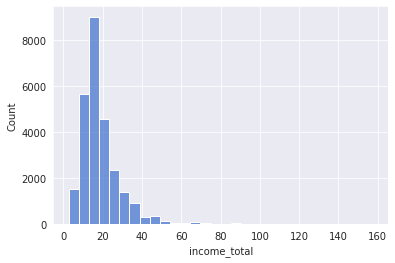

In [128]:
sns.histplot(data=train_df, x='income_total', bins=30)

In [129]:
train_df['income_total_range'] = pd.qcut(train_df['income_total'], 8)
test_df['income_total_range'] = pd.qcut(test_df['income_total'], 8)

In [130]:
train_df.groupby(['income_total_range'])['index'].count().to_frame()

,index
income_total_range,
"(2.6990000000000003, 9.45]",3328
"(9.45, 12.15]",3423
"(12.15, 13.5]",3727
"(13.5, 15.75]",2958
"(15.75, 19.8]",3147
"(19.8, 22.5]",4187
"(22.5, 28.8]",2388
"(28.8, 157.5]",3299


In [131]:
def income_to_range(df):    
    df['income_cat']=0
    df.loc[df['income_total']<=9.45,'income_cat']=0
    df.loc[(df['income_total']>9.45)&(df['income_total']<=12.15),'income_cat']=1
    df.loc[(df['income_total']>12.15)&(df['income_total']<=13.5),'income_cat']=2
    df.loc[(df['income_total']>13.5)&(df['income_total']<=15.75),'income_cat']=3
    df.loc[(df['income_total']>15.75)&(df['income_total']<=19.8),'income_cat']=4
    df.loc[(df['income_total']>19.8)&(df['income_total']<=22.5),'income_cat']=5
    df.loc[(df['income_total']>22.5)&(df['income_total']<=28.8),'income_cat']=6
    df.loc[(df['income_total']>28.8),'income_cat']=7

In [132]:
income_to_range(train_df)
income_to_range(test_df)

In [133]:
train_df.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_total_range,income_cat
0,0,0,0,0,0,20.25,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,"(19.8, 22.5]",5
1,1,0,0,1,1,24.75,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,"(22.5, 28.8]",6
2,2,1,1,1,0,45.00,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,"(28.8, 157.5]",7
3,3,0,0,1,0,20.25,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,"(19.8, 22.5]",5
4,4,0,1,1,0,15.75,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,"(13.5, 15.75]",3


<BarContainer object of 8 artists>

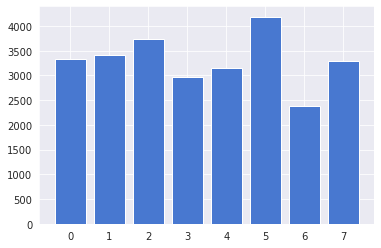

In [134]:
income_group = train_df.groupby('income_cat')['index'].count().to_frame().reset_index()
income_group.rename(columns={'index':'count'}, inplace=True)
plt.bar(range(8), income_group['count'])

'income_cat'를 생성했으니 income_total, income_total_range는 삭제한다.

In [135]:
train_df.drop(['income_total', 'income_total_range'], axis=1, inplace=True)
test_df.drop(['income_total', 'income_total_range'], axis=1, inplace=True)

In [136]:
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,5
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,6
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,7
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,3


In [137]:
test_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,income_cat
0,26457,1,1,0,0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,no jobs,2.0,-60.0,1
1,26458,0,0,1,0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0,2
2,26459,0,0,1,0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0,0
3,26460,1,1,0,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0,1
4,26461,0,1,1,0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0,5


In [138]:
train_df['income_type'].unique()

array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
       'Student'], dtype=object)

## 4. 마이너스 연속형 변수를 구간화
DAYS_BIRTH, DAYS_EMPLOYED, begin_month    
DAYS_BIRTH와 DAYS_EMPLOYED는 일수이므로 365를 나눠 년수로 바꿔준다.

In [139]:
def convert_days_birth_to_year(data):
    return -data//365

def convert_days_employed_to_year(data):
    return round(-data/365,2)

def convert_month_begin_to_year(data):
    return round(-data/12, 2)

In [140]:
train_df['age'] = convert_days_birth_to_year(train_df['DAYS_BIRTH'])
test_df['age'] = convert_days_birth_to_year(test_df['DAYS_BIRTH'])

DAYS_EMPLOYED의 양수값은 고용되지 않은 것이므로 0으로 바꿔준다.

In [141]:
train_df.loc[train_df['DAYS_EMPLOYED'] >= 0, 'DAYS_EMPLOYED'] = 0

In [142]:
train_df['career_year'] = convert_days_employed_to_year(train_df['DAYS_EMPLOYED'])
test_df['career_year'] = convert_days_employed_to_year(test_df['DAYS_EMPLOYED'])

In [143]:
train_df['begin_year'] = convert_month_begin_to_year(train_df['begin_month'])
test_df['begin_year'] = convert_month_begin_to_year(test_df['begin_month'])

In [144]:
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_cat,age,career_year,begin_year
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,5,38,12.90,0.50
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,6,31,4.22,0.42
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,7,52,12.15,1.83
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5,41,5.73,3.08
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,3,41,5.77,2.17


#### DAY_BIRTH

In [145]:
train_df.age.describe()

count    26457.000000
mean        43.213478
std         11.513590
min         21.000000
25%         34.000000
50%         42.000000
75%         53.000000
max         68.000000
Name: age, dtype: float64

나이는 10, 20, 30...으로 구간화 시킨다. 최대 나이가 67세이므로 구간화는 0~60으로 한다.

In [146]:
def age_to_range(df):
    df['age_cat']=0
    df.loc[df['age']<10,'age_cat']=0
    df.loc[(df['age']>=10)&(df['age']<20),'age_cat']=1
    df.loc[(df['age']>=20)&(df['age']<30),'age_cat']=2
    df.loc[(df['age']>=30)&(df['age']<40),'age_cat']=3
    df.loc[(df['age']>=40)&(df['age']<50),'age_cat']=4
    df.loc[(df['age']>=50)&(df['age']<60),'age_cat']=5
    df.loc[(df['age']>=60),'age_cat']=6    
    
    
age_to_range(train_df)
age_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_cat,age,career_year,begin_year,age_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,5,38,12.90,0.50,3
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,6,31,4.22,0.42,3
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,7,52,12.15,1.83,5
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5,41,5.73,3.08,4
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,3,41,5.77,2.17,4


#### DAYS_EMPLOYED

In [148]:
train_df.career_year.describe()

count    26457.000000
mean         6.023467
std          6.493533
min          0.000000
25%          1.120000
50%          4.220000
75%          8.640000
max         43.050000
Name: career_year, dtype: float64

경력도 10년 단위로 나눠서 구간화를 시켜준다.

In [149]:
def career_year_to_range(df):
    df['career_year_cat']=0
    df.loc[df['career_year']<=10,'career_year_cat']=0
    df.loc[(df['career_year']>10)&(df['career_year']<=20),'career_year_cat']=1
    df.loc[(df['career_year']>20)&(df['career_year']<=30),'career_year_cat']=2
    df.loc[(df['career_year']>30)&(df['career_year']<=40),'career_year_cat']=3
    df.loc[(df['career_year']>40),'career_year_cat']=4    
    
    
career_year_to_range(train_df)
career_year_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_cat,age,career_year,begin_year,age_cat,career_year_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,5,38,12.90,0.50,3,1
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,6,31,4.22,0.42,3,0
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,7,52,12.15,1.83,5,1
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5,41,5.73,3.08,4,0
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,3,41,5.77,2.17,4,0


####  begin_month
월 데이터이지만 년데이터로 바꾼다.

In [150]:
train_df.begin_year.describe()

count    26457.000000
mean         2.176932
std          1.379997
min         -0.000000
25%          1.000000
50%          2.000000
75%          3.250000
max          5.000000
Name: begin_year, dtype: float64

In [151]:
def begin_year_to_range(df):
    df['begin_year_cat']=0
    df.loc[df['begin_year']<1,'begin_year_cat']=0
    df.loc[(df['begin_year']>=1)&(df['begin_year']<2),'begin_year_cat']=1
    df.loc[(df['begin_year']>=2)&(df['begin_year']<3),'begin_year_cat']=2
    df.loc[(df['begin_year']>=3)&(df['begin_year']<4),'begin_year_cat']=3
    df.loc[(df['begin_year']>=4),'begin_year_cat']=4    
    
    
begin_year_to_range(train_df)
begin_year_to_range(test_df)

train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income_cat,age,career_year,begin_year,age_cat,career_year_cat,begin_year_cat
0,0,0,0,0,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,no jobs,2.0,-6.0,1.0,5,38,12.90,0.50,3,1,0
1,1,0,0,1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,6,31,4.22,0.42,3,0,0
2,2,1,1,1,0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,7,52,12.15,1.83,5,1,1
3,3,0,0,1,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,5,41,5.73,3.08,4,0,3
4,4,0,1,1,0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,3,41,5.77,2.17,4,0,2


구간화를 완료했으니 사용안하는 컬럼을 삭제한다.

In [152]:
train_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'age', 'career_year', 'begin_year'], axis=1, inplace=True)
test_df.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'age', 'career_year', 'begin_year'], axis=1, inplace=True)

## type 데이터 Label Encoding

In [153]:
print(train_df['income_type'].unique())
print(train_df['edu_type'].unique())
print(train_df['family_type'].unique())
print(train_df['house_type'].unique())

['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']


In [154]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()


train_df['income_type']=label_encoder.fit_transform(train_df['income_type'])
test_df['income_type']=label_encoder.transform(test_df['income_type'])
income_type_cat_name= label_encoder.classes_

train_df['edu_type']=label_encoder.fit_transform(train_df['edu_type'])
test_df['edu_type']=label_encoder.transform(test_df['edu_type'])
edu_type_cat_name= label_encoder.classes_

train_df['family_type']=label_encoder.fit_transform(train_df['family_type'])
test_df['family_type']=label_encoder.transform(test_df['family_type'])
family_type_cat_name= label_encoder.classes_

train_df['house_type']=label_encoder.fit_transform(train_df['house_type'])
test_df['house_type']=label_encoder.transform(test_df['house_type'])
house_type_cat_name= label_encoder.classes_

train_df['occyp_type']=label_encoder.fit_transform(train_df['occyp_type'])
test_df['occyp_type']=label_encoder.transform(test_df['occyp_type'])
occyp_type_cat_name= label_encoder.classes_

In [155]:
income_type_cat_name, edu_type_cat_name, family_type_cat_name, house_type_cat_name, occyp_type_cat_name

(array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Private service staff', 'Realty agents', 'Sales staff',
        'Secretaries', 'Security staff', 'Waiters/barmen staff', 'no jobs'],
       dtype=object))

In [156]:
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,credit,income_cat,age_cat,career_year_cat,begin_year_cat
0,0,0,0,0,0,0,1,1,2,1,0,0,0,18,2.0,1.0,5,3,1,0
1,1,0,0,1,1,0,4,0,1,1,0,0,1,8,3.0,1.0,6,3,0,0
2,2,1,1,1,0,4,1,1,1,1,0,1,0,10,2.0,2.0,7,5,1,1
3,3,0,0,1,0,0,4,1,1,1,0,1,0,14,2.0,0.0,5,4,0,3
4,4,0,1,1,0,2,1,1,1,1,0,0,0,10,2.0,2.0,3,4,0,2


## credit 데이터

In [157]:
train_df.credit.unique()

array([1., 2., 0.])

In [158]:
# credit의 데이터 타입이 float
train_df['credit'] = train_df['credit'].astype(int)
train_df.head()

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,credit,income_cat,age_cat,career_year_cat,begin_year_cat
0,0,0,0,0,0,0,1,1,2,1,0,0,0,18,2.0,1,5,3,1,0
1,1,0,0,1,1,0,4,0,1,1,0,0,1,8,3.0,1,6,3,0,0
2,2,1,1,1,0,4,1,1,1,1,0,1,0,10,2.0,2,7,5,1,1
3,3,0,0,1,0,0,4,1,1,1,0,1,0,14,2.0,0,5,4,0,3
4,4,0,1,1,0,2,1,1,1,1,0,0,0,10,2.0,2,3,4,0,2


In [160]:
train_df

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,credit,income_cat,age_cat,career_year_cat,begin_year_cat
0,0,0,0,0,0,0,1,1,2,1,0,0,0,18,2.0,1,5,3,1,0
1,1,0,0,1,1,0,4,0,1,1,0,0,1,8,3.0,1,6,3,0,0
2,2,1,1,1,0,4,1,1,1,1,0,1,0,10,2.0,2,7,5,1,1
3,3,0,0,1,0,0,4,1,1,1,0,1,0,14,2.0,0,5,4,0,3
4,4,0,1,1,0,2,1,1,1,1,0,0,0,10,2.0,2,3,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,2,2,4,1,1,1,0,0,0,3,4.0,1,5,3,0,0
26453,26453,0,0,1,1,4,1,2,1,1,0,0,0,18,2.0,2,4,4,0,3
26454,26454,0,1,0,0,4,4,0,5,1,0,0,0,3,2.0,2,7,2,0,2
26455,26455,1,0,1,0,4,2,3,1,1,0,0,0,8,1.0,2,4,2,0,4


In [159]:
test_df

,index,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,income_cat,age_cat,career_year_cat,begin_year_cat
0,26457,1,1,0,0,1,4,0,1,1,0,1,0,18,2.0,1,6,0,4
1,26458,0,0,1,0,2,1,1,1,1,0,1,0,3,2.0,2,5,2,3
2,26459,0,0,1,0,4,4,1,1,1,1,1,0,8,2.0,0,4,0,3
3,26460,1,1,0,0,0,4,1,1,1,1,0,0,4,2.0,1,5,0,3
4,26461,0,1,1,0,2,1,1,1,1,1,0,0,10,2.0,5,4,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,4,2,1,1,1,1,1,0,0,2.0,5,5,1,1
9996,36453,1,1,1,0,4,4,0,1,1,1,0,0,8,2.0,5,2,0,2
9997,36454,0,0,1,0,4,4,1,1,1,0,0,0,11,2.0,7,5,3,4
9998,36455,0,1,0,0,0,4,1,1,1,0,1,0,18,2.0,4,4,0,2


# 파생변수 만들기

의미있는 파생변수를 만들어 특성 간 관계를 모델에 알려주는 것이 매우 중요하다.
(car+reality) * income_cat 추가
FLAG_MOBIL 삭제
ALONE(faily_size=1)추가

In [161]:
del train_df['FLAG_MOBIL'], test_df['FLAG_MOBIL']

In [167]:
train_df['income_cat']

0        5
1        6
2        7
3        5
4        3
        ..
26452    5
26453    4
26454    7
26455    4
26456    0
Name: income_cat, Length: 26457, dtype: int64

In [169]:
train_df['assets'] = train_df.apply(lambda x: (1+x['income_cat'])*(x['car']+x['reality']+1), axis=1)
train_df['assets']

0         6.0
1        14.0
2        24.0
3        12.0
4        12.0
         ... 
26452     6.0
26453    10.0
26454    16.0
26455    10.0
26456     1.0
Name: assets, Length: 26457, dtype: float64

In [173]:
train_df['alone'] = train_df.apply(lambda x: x['family_size']==1, axis=1)
print(train_df['alone'].mean())
train_df['alone']

0.19310579430774463


0        False
1        False
2        False
3        False
4        False
         ...  
26452    False
26453    False
26454    False
26455     True
26456    False
Name: alone, Length: 26457, dtype: bool

In [174]:
test_df['assets'] = test_df.apply(lambda x: (1+x['income_cat'])*(x['car']+x['reality']+1), axis=1)
test_df['alone'] = test_df.apply(lambda x: x['family_size']==1, axis=1)

In [176]:
del train_df['index']

In [185]:
idx =  test_df['index']
y = train_df['credit']

test_df.drop(columns='index', inplace=True)
train_df.drop(columns='credit', inplace=True)

In [186]:
set(train_df.columns) == set(test_df.columns)

True

In [192]:
df_train_one_hot = pd.get_dummies(train_df, columns = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])
df_train_one_hot

,gender,car,reality,child_num,work_phone,phone,email,family_size,income_cat,age_cat,career_year_cat,begin_year_cat,assets,alone,income_type_0,income_type_1,income_type_2,income_type_3,income_type_4,edu_type_0,edu_type_1,edu_type_2,edu_type_3,edu_type_4,family_type_0,family_type_1,family_type_2,family_type_3,family_type_4,house_type_0,house_type_1,house_type_2,house_type_3,house_type_4,house_type_5,occyp_type_0,occyp_type_1,occyp_type_2,occyp_type_3,occyp_type_4,occyp_type_5,occyp_type_6,occyp_type_7,occyp_type_8,occyp_type_9,occyp_type_10,occyp_type_11,occyp_type_12,occyp_type_13,occyp_type_14,occyp_type_15,occyp_type_16,occyp_type_17,occyp_type_18
0,0,0,0,0,0,0,0,2.0,5,3,1,0,6.0,False,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,1,0,0,1,3.0,6,3,0,0,14.0,False,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,2.0,7,5,1,1,24.0,False,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,1,0,2.0,5,4,0,3,12.0,False,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,1,0,0,0,0,2.0,3,4,0,2,12.0,False,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0,0,0,2,0,0,0,4.0,5,3,0,0,6.0,False,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26453,0,0,1,1,0,0,0,2.0,4,4,0,3,10.0,False,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
26454,0,1,0,0,0,0,0,2.0,7,2,0,2,16.0,False,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26455,1,0,1,0,0,0,0,1.0,4,2,0,4,10.0,True,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [193]:
df_test_one_hot = pd.get_dummies(test_df, columns = ['income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type'])
df_test_one_hot

,gender,car,reality,child_num,work_phone,phone,email,family_size,income_cat,age_cat,career_year_cat,begin_year_cat,assets,alone,income_type_0,income_type_1,income_type_2,income_type_3,income_type_4,edu_type_0,edu_type_1,edu_type_2,edu_type_3,edu_type_4,family_type_0,family_type_1,family_type_2,family_type_3,family_type_4,house_type_0,house_type_1,house_type_2,house_type_3,house_type_4,house_type_5,occyp_type_0,occyp_type_1,occyp_type_2,occyp_type_3,occyp_type_4,occyp_type_5,occyp_type_6,occyp_type_7,occyp_type_8,occyp_type_9,occyp_type_10,occyp_type_11,occyp_type_12,occyp_type_13,occyp_type_14,occyp_type_15,occyp_type_16,occyp_type_17,occyp_type_18
0,1,1,0,0,0,1,0,2.0,1,6,0,4,4.0,False,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,1,0,2.0,2,5,2,3,6.0,False,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,1,0,2.0,0,4,0,3,2.0,False,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,2.0,1,5,0,3,4.0,False,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,2.0,5,4,2,0,18.0,False,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,1,1,0,1,1,0,2.0,5,5,1,1,18.0,False,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,1,1,1,0,1,0,0,2.0,5,2,0,2,18.0,False,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9997,0,0,1,0,0,0,0,2.0,7,5,3,4,16.0,False,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9998,0,1,0,0,0,1,0,2.0,4,4,0,2,10.0,False,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Modeling

In [194]:
pip install ray[tune]

     |████████████████████████████████| 49.6 MB 6.1 kB/s 
     |████████████████████████████████| 72 kB 521 kB/s 
     |████████████████████████████████| 124 kB 41.6 MB/s 


In [202]:
import sklearn.datasets
import sklearn.metrics
import os
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import ray
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback


def train_credit(config: dict):
    # This is a simple training function to be passed into Tune
    # Split into train and test set
    train_x, test_x, train_y, test_y = train_test_split(
        df_train_one_hot, y, test_size=0.25)
    # Build input matrices for XGBoost
    train_set = xgb.DMatrix(train_x, label=train_y)
    test_set = xgb.DMatrix(test_x, label=test_y)
    # Train the classifier, using the Tune callback
    xgb.train(
        config,
        train_set,
        evals=[(test_set, "eval")],
        verbose_eval=False,
        callbacks=[TuneReportCheckpointCallback(filename="model.xgb")])


def get_best_model_checkpoint(analysis):
    best_price_model = xgb.Booster()
    best_price_model.load_model(os.path.join(analysis.best_checkpoint, "model.xgb"))
    error =analysis.best_result["eval-mlogloss"]
    print(f"Best model parameters: {analysis.best_config}")
    print(f"Best model rmsle: {error:.4f}")
    return best_price_model


def tune_xgboost():
    search_space = {
        # You can mix constants with search space objects.
        "objective": "multi:softmax",
        "eval_metric": ["mlogloss"],
        "max_depth": tune.randint(3,9),
        "min_child_weight": tune.choice([1, 2, 3]),
        "subsample": tune.uniform(0.5, 1.0),
        "eta": tune.loguniform(1e-4, 2e-2),
        "booster": 'gbtree',
        "num_class": 3
    }
    # This will enable aggressive early stopping of bad trials.
    scheduler = ASHAScheduler(
        max_t=100,  # 40 training iterations
        grace_period=4,
        reduction_factor=2)

    analysis = tune.run(
        train_credit,
        metric="eval-mlogloss",
        mode="min",
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 2, "gpu": 0},
        config=search_space,
        num_samples=15,
        scheduler=scheduler)

    return analysis

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--server-address",
        type=str,
        default=None,
        required=False,
        help="The address of server to connect to if using "
        "Ray Client.")
    args, _ = parser.parse_known_args()

    if args.server_address:
        import ray
        ray.init(f"ray://{args.server_address}")

    analysis = tune_xgboost()

    # Load the best model checkpoint.
    if args.server_address:
        # If connecting to a remote server with Ray Client, checkpoint loading
        # should be wrapped in a task so it will execute on the server.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.tune.utils import force_on_current_node
        remote_fn = force_on_current_node(
            ray.remote(get_best_model_checkpoint))
        best_bst = ray.get(remote_fn.remote(analysis))
    else:
        best_bst = get_best_model_checkpoint(analysis)


Trial name,status,loc,eta,max_depth,min_child_weight,subsample
train_credit_20ae0_00000,RUNNING,,0.000334914,4,2,0.75496
train_credit_20ae0_00001,PENDING,,0.00533743,5,3,0.548393
train_credit_20ae0_00002,PENDING,,0.00235738,5,3,0.782921
train_credit_20ae0_00003,PENDING,,0.000200863,7,2,0.799348
train_credit_20ae0_00004,PENDING,,0.000948063,6,1,0.882502
train_credit_20ae0_00005,PENDING,,0.00011595,6,3,0.639975
train_credit_20ae0_00006,PENDING,,0.00286929,3,2,0.540108
train_credit_20ae0_00007,PENDING,,0.00198781,8,3,0.849391
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655


Result for train_credit_20ae0_00000:
  date: 2021-09-01_02-55-58
  done: false
  eval-mlogloss: 1.098448
  experiment_id: 2f80ccfb3f5b429aa6206e9889edbb06
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5326
  should_checkpoint: true
  time_since_restore: 0.39745616912841797
  time_this_iter_s: 0.39745616912841797
  time_total_s: 0.39745616912841797
  timestamp: 1630464958
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00000
  
Result for train_credit_20ae0_00000:
  date: 2021-09-01_02-56-00
  done: true
  eval-mlogloss: 1.097336
  experiment_id: 2f80ccfb3f5b429aa6206e9889edbb06
  experiment_tag: 0_eta=0.00033491,max_depth=4,min_child_weight=2,subsample=0.75496
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5326
  time_since_restore: 2.001359701156616
  time_this_iter_s: 0.1641228199005127
  time_total_s: 2.001359701156616
  timestamp: 1630464960
  timesteps_since_restore: 0
  training_ite

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00001,RUNNING,,0.00533743,5,3,0.548393,,,
train_credit_20ae0_00002,PENDING,,0.00235738,5,3,0.782921,,,
train_credit_20ae0_00003,PENDING,,0.000200863,7,2,0.799348,,,
train_credit_20ae0_00004,PENDING,,0.000948063,6,1,0.882502,,,
train_credit_20ae0_00005,PENDING,,0.00011595,6,3,0.639975,,,
train_credit_20ae0_00006,PENDING,,0.00286929,3,2,0.540108,,,
train_credit_20ae0_00007,PENDING,,0.00198781,8,3,0.849391,,,
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777,,,
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655,,,
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,


Result for train_credit_20ae0_00001:
  date: 2021-09-01_02-56-02
  done: false
  eval-mlogloss: 1.096594
  experiment_id: 79326c02272840ccb672ad5c757e70cd
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5327
  should_checkpoint: true
  time_since_restore: 0.46252965927124023
  time_this_iter_s: 0.46252965927124023
  time_total_s: 0.46252965927124023
  timestamp: 1630464962
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00001
  
Result for train_credit_20ae0_00001:
  date: 2021-09-01_02-56-04
  done: true
  eval-mlogloss: 1.079313
  experiment_id: 79326c02272840ccb672ad5c757e70cd
  experiment_tag: 1_eta=0.0053374,max_depth=5,min_child_weight=3,subsample=0.54839
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5327
  time_since_restore: 2.546727418899536
  time_this_iter_s: 0.20549798011779785
  time_total_s: 2.546727418899536
  timestamp: 1630464964
  timesteps_since_restore: 0
  training_ite

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00002,RUNNING,172.28.0.2:5393,0.00235738,5,3,0.782921,1,0.372467,1.09773
train_credit_20ae0_00003,PENDING,,0.000200863,7,2,0.799348,,,
train_credit_20ae0_00004,PENDING,,0.000948063,6,1,0.882502,,,
train_credit_20ae0_00005,PENDING,,0.00011595,6,3,0.639975,,,
train_credit_20ae0_00006,PENDING,,0.00286929,3,2,0.540108,,,
train_credit_20ae0_00007,PENDING,,0.00198781,8,3,0.849391,,,
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777,,,
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655,,,
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,


Result for train_credit_20ae0_00002:
  date: 2021-09-01_02-56-07
  done: true
  eval-mlogloss: 1.095066
  experiment_id: ef34dd4538514e01a815ac403116a0bc
  hostname: 92464fd07f96
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  pid: 5393
  time_since_restore: 0.9894008636474609
  time_this_iter_s: 0.17271661758422852
  time_total_s: 0.9894008636474609
  timestamp: 1630464967
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 20ae0_00002
  
Result for train_credit_20ae0_00003:
  date: 2021-09-01_02-56-10
  done: false
  eval-mlogloss: 1.098565
  experiment_id: e72a41402b4649f387fabb637a8997a2
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5418
  should_checkpoint: true
  time_since_restore: 0.44678568840026855
  time_this_iter_s: 0.44678568840026855
  time_total_s: 0.44678568840026855
  timestamp: 1630464970
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00003
  
Result for train_credit_20ae0_00003:
  date: 

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00004,RUNNING,172.28.0.2:5446,0.000948063,6,1,0.882502,1,0.405518,1.09824
train_credit_20ae0_00005,PENDING,,0.00011595,6,3,0.639975,,,
train_credit_20ae0_00006,PENDING,,0.00286929,3,2,0.540108,,,
train_credit_20ae0_00007,PENDING,,0.00198781,8,3,0.849391,,,
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777,,,
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655,,,
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,
train_credit_20ae0_00012,PENDING,,0.0039301,7,1,0.872892,,,
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,


Result for train_credit_20ae0_00004:
  date: 2021-09-01_02-56-14
  done: true
  eval-mlogloss: 1.097173
  experiment_id: 487b140031214eb886808235616f4c25
  hostname: 92464fd07f96
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  pid: 5446
  time_since_restore: 1.104919672012329
  time_this_iter_s: 0.19825506210327148
  time_total_s: 1.104919672012329
  timestamp: 1630464974
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 20ae0_00004
  


2021-09-01 02:56:14,870	WARNING worker.py:1215 -- The actor or task with ID ffffffffffffffff42725fe524bd6f0175a0539001000000 cannot be scheduled right now. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this actor or task, which may take time to install.  Otherwise, this is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increasing the resources available to this Ray cluster.
Required resources for this actor or task: {CPU_group_0_c005457a6e543d3fa8e6ce8eef14199e: 2.000000}, {CPU_group_c005457a6e543d3fa8e6ce8eef14199e: 2.000000}
Available resources on this node: {0.000000/2.000000 CPU, 7.288017 GiB/7.288017 GiB memory, 3.644008 GiB/3.644008 GiB object_store_memory, 1000.000000/1000.000000 bundle_group_0_c005457a6e543d3fa8e6ce8eef14199e, 1000.000000/1000.000000 bundle_group_c005457a6e543d3fa8e6ce8eef14199e, 0.000000/2.000000 CPU_group_0_c005457a6e543d3fa8

Result for train_credit_20ae0_00005:
  date: 2021-09-01_02-56-16
  done: false
  eval-mlogloss: 1.098602
  experiment_id: b64ca88218e14af089ab118b4935d70e
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5476
  should_checkpoint: true
  time_since_restore: 0.4293203353881836
  time_this_iter_s: 0.4293203353881836
  time_total_s: 0.4293203353881836
  timestamp: 1630464976
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00005
  
Result for train_credit_20ae0_00005:
  date: 2021-09-01_02-56-17
  done: true
  eval-mlogloss: 1.098404
  experiment_id: b64ca88218e14af089ab118b4935d70e
  hostname: 92464fd07f96
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  pid: 5476
  time_since_restore: 1.180783748626709
  time_this_iter_s: 0.23737263679504395
  time_total_s: 1.180783748626709
  timestamp: 1630464977
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 20ae0_00005
  
Result for train_credit_20ae0_00006:
  date: 2021-

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00006,RUNNING,172.28.0.2:5501,0.00286929,3,2,0.540108,1,0.332256,1.09752
train_credit_20ae0_00007,PENDING,,0.00198781,8,3,0.849391,,,
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777,,,
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655,,,
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,
train_credit_20ae0_00012,PENDING,,0.0039301,7,1,0.872892,,,
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734


Result for train_credit_20ae0_00006:
  date: 2021-09-01_02-56-21
  done: true
  eval-mlogloss: 1.087984
  experiment_id: 73dc61cd2ca24b979cb4f2a2a64597fc
  experiment_tag: 6_eta=0.0028693,max_depth=3,min_child_weight=2,subsample=0.54011
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5501
  time_since_restore: 1.614196538925171
  time_this_iter_s: 0.12739968299865723
  time_total_s: 1.614196538925171
  timestamp: 1630464981
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 20ae0_00006
  
Result for train_credit_20ae0_00007:
  date: 2021-09-01_02-56-23
  done: false
  eval-mlogloss: 1.097834
  experiment_id: bf09e390d75845b9ada6980a39ce4ff2
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5529
  should_checkpoint: true
  time_since_restore: 0.5030641555786133
  time_this_iter_s: 0.5030641555786133
  time_total_s: 0.5030641555786133
  timestamp: 1630464983
  timesteps_since_restore: 0
  training_itera

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00007,RUNNING,172.28.0.2:5529,0.00198781,8,3,0.849391,6,1.9405,1.09394
train_credit_20ae0_00008,PENDING,,0.00244087,7,3,0.857777,,,
train_credit_20ae0_00009,PENDING,,0.0178139,7,2,0.896655,,,
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,
train_credit_20ae0_00012,PENDING,,0.0039301,7,1,0.872892,,,
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931


Result for train_credit_20ae0_00007:
  date: 2021-09-01_02-56-25
  done: true
  eval-mlogloss: 1.092388
  experiment_id: bf09e390d75845b9ada6980a39ce4ff2
  hostname: 92464fd07f96
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  pid: 5529
  time_since_restore: 2.5677168369293213
  time_this_iter_s: 0.2868506908416748
  time_total_s: 2.5677168369293213
  timestamp: 1630464985
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 20ae0_00007
  
Result for train_credit_20ae0_00008:
  date: 2021-09-01_02-56-28
  done: false
  eval-mlogloss: 1.097675
  experiment_id: 1892fa0308464451b1d7efd743d5f415
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5559
  should_checkpoint: true
  time_since_restore: 0.4311394691467285
  time_this_iter_s: 0.4311394691467285
  time_total_s: 0.4311394691467285
  timestamp: 1630464988
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00008
  
Result for train_credit_20ae0_00008:
  date: 2021

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00009,RUNNING,172.28.0.2:5587,0.0178139,7,2,0.896655,1,0.431044,1.09181
train_credit_20ae0_00010,PENDING,,0.000512608,6,1,0.567334,,,
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,
train_credit_20ae0_00012,PENDING,,0.0039301,7,1,0.872892,,,
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833


Result for train_credit_20ae0_00009:
  date: 2021-09-01_02-56-34
  done: true
  eval-mlogloss: 1.039261
  experiment_id: 305e69e8845b4e9cb490697825fe1d18
  experiment_tag: 9_eta=0.017814,max_depth=7,min_child_weight=2,subsample=0.89666
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5587
  time_since_restore: 2.6237170696258545
  time_this_iter_s: 0.21298527717590332
  time_total_s: 2.6237170696258545
  timestamp: 1630464994
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 20ae0_00009
  
Result for train_credit_20ae0_00010:
  date: 2021-09-01_02-56-37
  done: false
  eval-mlogloss: 1.098397
  experiment_id: 3d857d2883cb4f2085c8cf2956145640
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5617
  should_checkpoint: true
  time_since_restore: 0.43364548683166504
  time_this_iter_s: 0.43364548683166504
  time_total_s: 0.43364548683166504
  timestamp: 1630464997
  timesteps_since_restore: 0
  training_i

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00010,RUNNING,172.28.0.2:5617,0.000512608,6,1,0.567334,3,0.955626,1.09802
train_credit_20ae0_00011,PENDING,,0.000108851,5,1,0.686292,,,
train_credit_20ae0_00012,PENDING,,0.0039301,7,1,0.872892,,,
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833
train_credit_20ae0_00004,TERMINATED,,0.000948063,6,1,0.882502,4,1.10492,1.09717


Result for train_credit_20ae0_00010:
  date: 2021-09-01_02-56-37
  done: true
  eval-mlogloss: 1.097833
  experiment_id: 3d857d2883cb4f2085c8cf2956145640
  hostname: 92464fd07f96
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  pid: 5617
  time_since_restore: 1.1923491954803467
  time_this_iter_s: 0.23672270774841309
  time_total_s: 1.1923491954803467
  timestamp: 1630464997
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 20ae0_00010
  
Result for train_credit_20ae0_00011:
  date: 2021-09-01_02-56-40
  done: false
  eval-mlogloss: 1.098613
  experiment_id: 79061ba2df924530b2662cb1b0a28d55
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5645
  should_checkpoint: true
  time_since_restore: 0.3895893096923828
  time_this_iter_s: 0.3895893096923828
  time_total_s: 0.3895893096923828
  timestamp: 1630465000
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00011
  
Result for train_credit_20ae0_00011:
  date: 202

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00012,RUNNING,172.28.0.2:5673,0.0039301,7,1,0.872892,1,0.444348,1.0971
train_credit_20ae0_00013,PENDING,,0.000173744,7,1,0.964385,,,
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833
train_credit_20ae0_00004,TERMINATED,,0.000948063,6,1,0.882502,4,1.10492,1.09717
train_credit_20ae0_00005,TERMINATED,,0.00011595,6,3,0.639975,4,1.18078,1.0984
train_credit_20ae0_00006,TERMINATED,,0.00286929,3,2,0.540108,10,1.6142,1.08798


Result for train_credit_20ae0_00012:
  date: 2021-09-01_02-56-45
  done: true
  eval-mlogloss: 1.083973
  experiment_id: fe444aac46b64dbc84cab570baaa8bd0
  experiment_tag: 12_eta=0.0039301,max_depth=7,min_child_weight=1,subsample=0.87289
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5673
  time_since_restore: 2.7093088626861572
  time_this_iter_s: 0.22224783897399902
  time_total_s: 2.7093088626861572
  timestamp: 1630465005
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 20ae0_00012
  
Result for train_credit_20ae0_00013:
  date: 2021-09-01_02-56-47
  done: false
  eval-mlogloss: 1.098574
  experiment_id: 5a0dfaabafb34c39adcbd264b4fff5c3
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5703
  should_checkpoint: true
  time_since_restore: 0.41678524017333984
  time_this_iter_s: 0.41678524017333984
  time_total_s: 0.41678524017333984
  timestamp: 1630465007
  timesteps_since_restore: 0
  training

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00013,RUNNING,172.28.0.2:5703,0.000173744,7,1,0.964385,2,0.73178,1.09845
train_credit_20ae0_00014,PENDING,,0.00677307,8,1,0.572957,,,
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833
train_credit_20ae0_00004,TERMINATED,,0.000948063,6,1,0.882502,4,1.10492,1.09717
train_credit_20ae0_00005,TERMINATED,,0.00011595,6,3,0.639975,4,1.18078,1.0984
train_credit_20ae0_00006,TERMINATED,,0.00286929,3,2,0.540108,10,1.6142,1.08798
train_credit_20ae0_00007,TERMINATED,,0.00198781,8,3,0.849391,8,2.56772,1.09239


Result for train_credit_20ae0_00013:
  date: 2021-09-01_02-56-48
  done: true
  eval-mlogloss: 1.098378
  experiment_id: 5a0dfaabafb34c39adcbd264b4fff5c3
  hostname: 92464fd07f96
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  pid: 5703
  time_since_restore: 1.1830103397369385
  time_this_iter_s: 0.22051239013671875
  time_total_s: 1.1830103397369385
  timestamp: 1630465008
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 20ae0_00013
  
Result for train_credit_20ae0_00014:
  date: 2021-09-01_02-56-51
  done: false
  eval-mlogloss: 1.096033
  experiment_id: 231ae878665141759f0bd127d40e74f3
  hostname: 92464fd07f96
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 5731
  should_checkpoint: true
  time_since_restore: 0.5153055191040039
  time_this_iter_s: 0.5153055191040039
  time_total_s: 0.5153055191040039
  timestamp: 1630465011
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 20ae0_00014
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00014,RUNNING,172.28.0.2:5731,0.00677307,8,1,0.572957,8,2.68367,1.07856
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833
train_credit_20ae0_00004,TERMINATED,,0.000948063,6,1,0.882502,4,1.10492,1.09717
train_credit_20ae0_00005,TERMINATED,,0.00011595,6,3,0.639975,4,1.18078,1.0984
train_credit_20ae0_00006,TERMINATED,,0.00286929,3,2,0.540108,10,1.6142,1.08798
train_credit_20ae0_00007,TERMINATED,,0.00198781,8,3,0.849391,8,2.56772,1.09239
train_credit_20ae0_00008,TERMINATED,,0.00244087,7,3,0.857777,8,2.20959,1.09126


Result for train_credit_20ae0_00014:
  date: 2021-09-01_02-56-53
  done: true
  eval-mlogloss: 1.073771
  experiment_id: 231ae878665141759f0bd127d40e74f3
  experiment_tag: 14_eta=0.0067731,max_depth=8,min_child_weight=1,subsample=0.57296
  hostname: 92464fd07f96
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  pid: 5731
  time_since_restore: 3.293456792831421
  time_this_iter_s: 0.30229663848876953
  time_total_s: 3.293456792831421
  timestamp: 1630465013
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 20ae0_00014
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),eval-mlogloss
train_credit_20ae0_00000,TERMINATED,,0.000334914,4,2,0.75496,10,2.00136,1.09734
train_credit_20ae0_00001,TERMINATED,,0.00533743,5,3,0.548393,10,2.54673,1.07931
train_credit_20ae0_00002,TERMINATED,,0.00235738,5,3,0.782921,4,0.989401,1.09507
train_credit_20ae0_00003,TERMINATED,,0.000200863,7,2,0.799348,4,1.24052,1.09833
train_credit_20ae0_00004,TERMINATED,,0.000948063,6,1,0.882502,4,1.10492,1.09717
train_credit_20ae0_00005,TERMINATED,,0.00011595,6,3,0.639975,4,1.18078,1.0984
train_credit_20ae0_00006,TERMINATED,,0.00286929,3,2,0.540108,10,1.6142,1.08798
train_credit_20ae0_00007,TERMINATED,,0.00198781,8,3,0.849391,8,2.56772,1.09239
train_credit_20ae0_00008,TERMINATED,,0.00244087,7,3,0.857777,8,2.20959,1.09126
train_credit_20ae0_00009,TERMINATED,,0.0178139,7,2,0.896655,10,2.62372,1.03926


2021-09-01 02:56:54,065	INFO tune.py:561 -- Total run time: 58.19 seconds (57.98 seconds for the tuning loop).


Best model parameters: {'objective': 'multi:softmax', 'eval_metric': ['mlogloss'], 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8966553786434872, 'eta': 0.017813932468901617, 'booster': 'gbtree', 'num_class': 3}
Best model rmsle: 1.0393


In [203]:
analysis.best_config

{'booster': 'gbtree',
 'eta': 0.017813932468901617,
 'eval_metric': ['mlogloss'],
 'max_depth': 7,
 'min_child_weight': 2,
 'num_class': 3,
 'objective': 'multi:softmax',
 'subsample': 0.8966553786434872}

In [204]:
import pickle
pickle.dump(best_bst, open("xgb_last.pkl", "wb"))
loaded_bst = pickle.load(open("xgb_last.pkl", "rb"))

In [207]:
dtrain = xgb.DMatrix(df_train_one_hot, label=y)
dtest = xgb.DMatrix(df_test_one_hot)
# y_pred = loaded_bst.predict(train_set)

In [ ]:
# Feval()
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    diffs = np.exp(predictions) - np.exp(labels)
    squared_diffs = np.square(diffs)
    avg = np.mean(squared_diffs)
    return ('rmse_exp', np.sqrt(avg))

In [208]:
cv_output = xgb.cv(params,
                   dtrain,                        
                   num_boost_round=5000,         # 학습 횟수
                   early_stopping_rounds=10,    # overfitting 방지
                   nfold=10,                      # 높을 수록 실제 검증값에 가까워지고 낮을 수록 빠름
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
                   feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )
# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')

KeyboardInterrupt: ignored

# Reference
## EDA
* https://www.dacon.io/competitions/official/235713/codeshare/2519?page=1&dtype=view
## Preprocessing
* https://www.dacon.io/competitions/official/235713/codeshare/2475?page=1&dtype=recent